# Analyze A/B Test Results<br/> E-commerce website

## Tabel of contents 

- [Introduction](#intro)
- [Dataset overview](#overview)
- [Data cleaning](#clean)
- [Dataset summary statistics and proportions](#props)
- [A/B Test](#ab_test)
- [Simulation](#simul)
- [A regression approach](#regression)
- [Timestamp Analysis](#time)
- [Conclusion](#Conclusion)

<a id='intro'></a>
## Introduction

Should we choose the new page or the old page for our E-commerce website?, a good question, no? <br/>
A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help a company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='overview'></a>
## Dataset Overview
To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df=pd.read_csv('ab_data.csv',parse_dates=[1])
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [4]:
for col in df.dtypes[2:].index:
    print(f"{col} unique values: ", df[col].unique())

group unique values:  ['control' 'treatment']
landing_page unique values:  ['old_page' 'new_page']
converted unique values:  [0 1]


The dataset is composed of 294,478 entries containing different information like user id, the time user visited the website, the user group, landing page, and whether if they converted or not.

<a id='clean'></a>
## Data Cleaning

In [5]:
df.duplicated().sum()

0

Looks like there is no duplicated entries

The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

In [7]:
df.user_id.value_counts()

805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: user_id, Length: 290584, dtype: int64

Although there is no duplicated entries, some users had at most two occurances in the dataset.

In [8]:
id_dupes=df[df.user_id.duplicated(keep=False)].sort_values('user_id')
duped_groups=(id_dupes)
duped_groups

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
...,...,...,...,...,...
142354,945703,2017-01-08 19:40:51.169351,control,new_page,0
186960,945797,2017-01-13 17:23:21.750962,control,old_page,0
40370,945797,2017-01-11 03:04:49.433736,control,new_page,1
165143,945971,2017-01-16 10:09:18.383183,control,old_page,0


repeated user ids are due to the fact they visited two different pages when they really shouldn't!

The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [9]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

1965

The number of times when the "group" is `control` but "landing_page" is not a `old_page`.

In [10]:
df.query('group == "control" and landing_page != "old_page"').shape[0]

1928

In [11]:
q=df.query('group == "treatment" and landing_page != "new_page"').index
z=df.query('group == "control" and landing_page != "old_page"').index
c=q.append(z)
len(c),len(q)+len(z)

(3893, 3893)

In [12]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

rows don't have any missing values

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

Removing inaccurate rows

In [13]:
# Remove the inaccurate rows
df2=df.drop(index=c)
df2.shape[0]
df2.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old_page        145274
treatment  new_page        145311
Name: landing_page, dtype: int64

In [14]:
# Double Check all of the incorrect rows were removed
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Number of unique users in the cleaned dataset

In [15]:
df2.user_id.nunique()

290584

How many entries does each user have?

In [16]:
df2.user_id.value_counts().head()

773192    2
851104    1
688307    1
718297    1
838144    1
Name: user_id, dtype: int64

One user in particular still having two entries id 773192

In [17]:
df2[df2.duplicated(subset='user_id',keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


He/she has two visits and both are not converted.

 Removing **one** of the rows with a duplicate **user_id**, from the datset.

In [18]:
# Remove one of the rows with a duplicate user_id..
df2.drop_duplicates(subset='user_id',inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
print(df2.duplicated(subset='user_id').sum())
df2.loc[df2.user_id==773192]

0


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


<a id='props'></a>
## Dataset summary statistics and proportions

What is the probability of an individual converting regardless of the page they receive?

Number of visitors in control group:  145274
Number of visitors in Treatment group:  145310


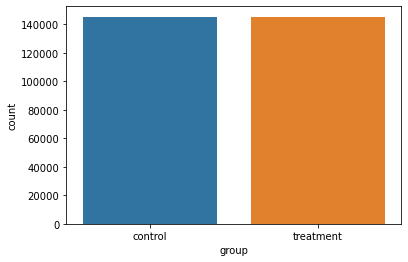

In [19]:
sns.countplot(data=df2,x='group');
print("Number of visitors in control group: ",df2.query('group=="control"').shape[0])
print("Number of visitors in Treatment group: ",df2.query('group=="treatment"').shape[0])

What is probability of conversion regardless of the group?

In [20]:
p_conv=df2['converted'].mean()
"{:.2%}".format(p_conv)

'11.96%'

Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
control_cr=df2.query('group=="control"')['converted'].mean()
"{:.2%}".format(control_cr)

'12.04%'

Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
treatment_cr=df2.query('group=="treatment"')['converted'].mean()
"{:.2%}".format(treatment_cr)

'11.88%'

Calculating the observed difference between the `new_page` conversions and `old_page` conversions in our **sample** dataset. 

In [23]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=treatment_cr - control_cr
"{:.2%}".format(obs_diff)

'-0.16%'

What is the probability that an individual received the `new_page`?

In [24]:
p_treatment=(df2.landing_page == 'new_page').mean()
"{:.2%}".format(p_treatment)

'50.01%'

What is the probability that an individual received the `old_page`?

In [25]:
p_control=(df2.landing_page == 'old_page').mean()
"{:.2%}".format(p_control)

'49.99%'

do the `treatment` group users lead to more conversions?

According to bayes theorem: <br/>
If we want to get whether the new `new_page` leads to more conversion rate, then we need to find the proportion of the `treatment` group given that they `converted`, in other words we need to calculate $P (treatment  | conv) $ <br/>

$$ 
P (treatment  | conv) = \frac{P(treatment)P(conv | treatment )}{P(converted)} 
$$ 
<br/>

$$ 
P (control  | conv) = \frac{P(control)P(conv | control )}{P(converted)} 
$$ 
<br/>

$P(treatment)= $ `p_treatment`<br/>
$P(conv | treatment )= $ `treatment_cr`<br/>
$P(control)= $ `p_control`<br/>
$P(conv | control )= $ `control_cr`<br/>
$P(converted)= $ `p_conv`<br/>

And so the $P (treatment  | conv) $ is:

In [26]:
P_treatmeant_conv=p_treatment * treatment_cr / p_conv
"{:.2%}".format(P_treatmeant_conv)

'49.68%'

And the $P (control  | conv) $ is:

In [27]:
P_control_conv=p_control * control_cr / p_conv
"{:.2%}".format(P_control_conv)

'50.32%'

It looks like the `old_page` leads to slightly more conversion than the `new_page`, however they are almost the same, In the next section we will attempt to calculate how significant is this observation from our sample and try to infer that to the actual population (**All the website users**)

<a id='ab_test'></a>
## A/B Test

### Null Hypothesis $H_0$ Testing

Since the difference between the two conversion rates is **very small**. Lets assume that our null hypothesis $H_0$ that the `new_page` conversion rate $p_{new}$ is  the same or lower than conversion rate of `old_page` $p_{old}$ until the oppoiste proves to be true.  And so, our assumption is: <br><br>

$$H_0: p_{new} \leq p_{old} $$
$$H_1: p_{new} > p_{old} $$
$$ H_0: p_{new} - p_{old} \leq 0 $$
$$ H_1: p_{new}-p_{old} > 0 $$


In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the datset.


- Compute the difference in the **"converted" probability** for the two samples above. 


- Perform the **sampling distribution** for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

<a id='simul'></a>
## Simulation

What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [28]:
p_con=df2['converted'].mean()
p_new=p_conv
"{:.2%}".format(p_new)

'11.96%'

What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [54]:
p_old=p_conv
"{:.2%}".format(p_old)

'11.96%'

What is $n_{new}$, the number of individuals in the treatment group?


In [55]:
n_new=df2.query("group=='treatment'and landing_page=='new_page'").shape[0]
n_new

145310

What is $n_{old}$, the number of individuals in the control group?

In [56]:
n_old=df2.query("group=='control'and landing_page=='old_page'").shape[0]
n_old

145274

Simulated 10,000 samples of the `new_page` conversion rates

In [57]:
new_page_bootstrap = np.random.binomial(n_new, p_new, 10000)/n_new

Simulated 10,000 samples of the `old_page` conversion rates

In [58]:
old_page_bootstrap= np.random.binomial(n_old,p_old,10000)/n_old

Calculating the difference between the the two simulation

In [59]:
p_diff = new_page_bootstrap - old_page_bootstrap

Simualting the null hypothesis with the same standard deviation of `p_diff`

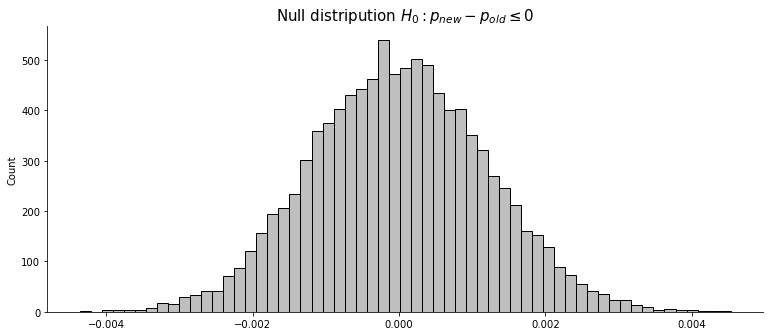

In [60]:
null_dsprt=np.random.normal(0,np.std(p_diff),p_diff.size)
sns.displot(null_dsprt,color='#aaaaaa',height=4.5,aspect=2.4);
plt.title(r'Null distripution $ H_0: p_{new} - p_{old} \leq 0 $',fontsize=15);

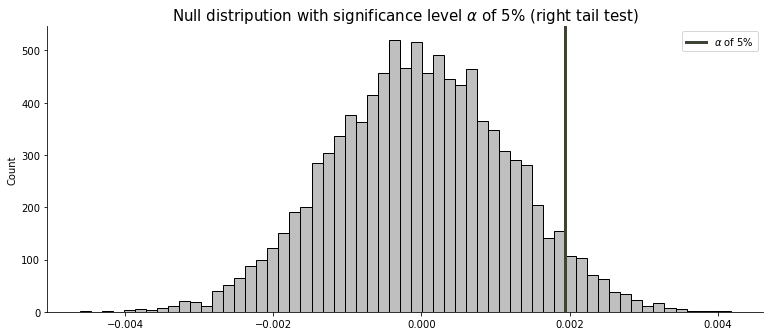

In [61]:
null_dsprt=np.random.normal(0,np.std(p_diff),p_diff.size)
sns.displot(null_dsprt,color='#aaaaaa',height=4.5,aspect=2.4);
plt.axvline(np.percentile(null_dsprt,95),color='#3d4435',lw=3)
plt.title(r'Null distripution with significance level $\alpha$ of 5% (right tail test)',fontsize=15);
plt.legend(labels=[r'$\alpha$ of 5%']);

In [62]:
null=pd.DataFrame(null_dsprt,columns=['differences'])

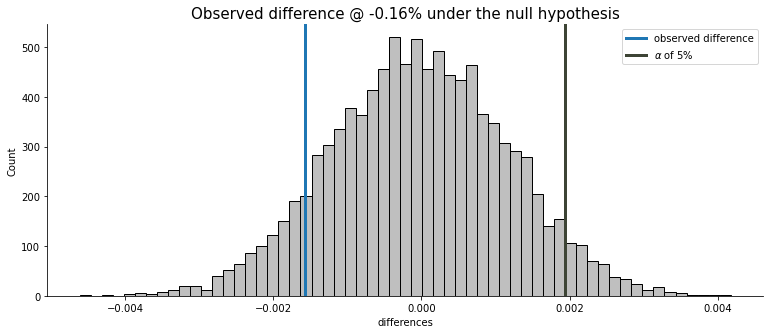

In [63]:
obs="{:.2%}".format(obs_diff)
sns.displot(data=null,x='differences',color='#aaaaaa',height=4.5,aspect=2.4);
plt.axvline(obs_diff,lw=3)
plt.axvline(np.percentile(null_dsprt,95),color='#3d4435',lw=3)
plt.title('Observed difference @ {} under the null hypothesis'.format(obs),fontsize=15)
plt.legend(labels=['observed difference',r'$\alpha$ of 5%'],loc='upper right');

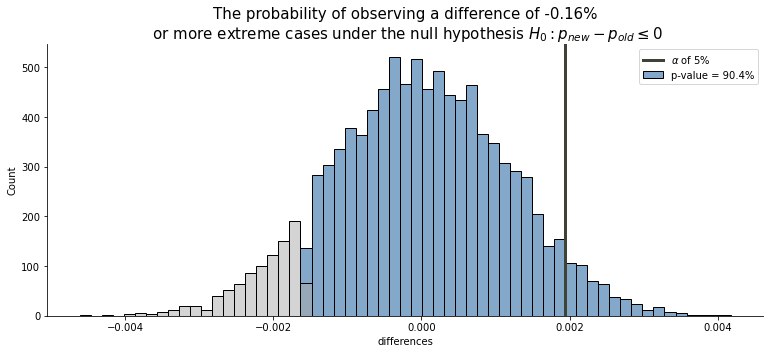

In [64]:
null['p-value']=null['differences'].apply(lambda x: 1 if ((x > obs_diff)) else 0)
strin = 'The probability of observing a difference of {}\n or more extreme cases under the null hypothesis'.format(obs)
strin = strin + r" $ H_0: p_{new} - p_{old} \leq 0 $"
sns.displot(data=null,x='differences',hue='p-value',palette=['#aaaaaa','#0b5394'],legend=False,height=4.5,aspect=2.4);
plt.axvline(np.percentile(null_dsprt,95),color='#3d4435',lw=3)
plt.title(strin,fontsize=15);
plt.legend(labels=[r'$\alpha$ of 5%',"p-value = {:.1%}".format(null['p-value'].mean())],loc='upper right');

### And so our calculated p-value is

In [65]:
"{:.2%}".format(null['p-value'].mean())

'90.42%'

A p-value of 90.02% is way too large to say that our observed difference of conversions came from the realm of chance, since our significance level $\alpha$ is 5%, and our p-value is large than $\alpha$, therefore our conclusion is:
- **We fail to find enough evidence to reject the null hypothesis that we've assumed previously to be true stating that**
- **The conversion rate of the `new_page` is the same or lower than the conversion rate of the `old_page` $ H_0: p_{new}  \leq  p_{old} $**

So now we know for a fact that we can't favour the alternate hypothesis $ H_1: p_{new}  >  p_{old} $ over our null hypothesis $H_0: p_{new}  \leq  p_{old} $, we still have two question in mind. 
- Is the conversion rate for both pages is the same $ p_{new}  =  p_{old}$ ? 
- or  is the conversion rate for the `new_page` lower than the `old_page` $ p_{new}  <  p_{old}$?

I'll be using built-in method to conduct a two-sided test, where our null hypothesis $H_0: p_{new}  =  p_{old} $ and our alternate is $H_1: p_{new} \neq  p_{old} $

However, $H_1: p_{new} \neq  p_{old} $ can be translated into:
$$ p_{new} >  p_{old} $$
or
$$ p_{new} <  p_{old} $$


but we previously know  from right tailed test that:
 $$p_{new}  \leq  p_{old} $$

And this makes our current alternate hypothesis for the two-sided test should we reject the null: $ H_1: p_{new}  <  p_{old} $

In [66]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
print('number of conversions with the old_page:',convert_old)
      
# number of conversions with the new_page
convert_new =df2.query("landing_page == 'new_page' and converted == 1").shape[0]
print('number of conversions with the new_page:',convert_new)

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'").shape[0]
print('number of individuals who were shown the old_page:',n_old)
      

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'").shape[0]
print('number of individuals who received new_page:',n_new)


number of conversions with the old_page: 17489
number of conversions with the new_page: 17264
number of individuals who were shown the old_page: 145274
number of individuals who received new_page: 145310


In [67]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new,convert_old],
                                              nobs=[n_new,n_old],alternative='two-sided')
print(z_score, p_value)

-1.3109241984234394 0.18988337448195103


 So our calculated p-value for the two-sided test and it was 18.99% which is greater than our signiface level $\alpha$ of 5%, concluding that:
- **We fail to find enough evidence to reject the null hypothesis that we've assumed previously to be true stating that**
- **The conversion rate of the `new_page` is the same as the conversion rate of the `old_page` $ H_0: p_{new}  =  p_{old} $** 

<a id='regression'></a>
## A regression approach

Since each row in the dataset  is either a conversion or no conversion, we'd be performing a logistic regression.

Logistic Regression

The goal is to use **statsmodels** library to fit the regression model we've specified above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the dataset:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [68]:
df2['intercept']=1
df2[['control','treatment']]=pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [69]:
df2.drop(columns='control',inplace=True)

In [70]:
df2.rename(columns={'treatment':'ab_page'},inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Now we're going to use **statsmodels** to instantiate our regression model on the two columns we've created above, then fit the model to predict whether or not an individual converts. 

In [71]:
logm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=logm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [72]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-12-30 14:41 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

So the Coef. we've calculated for `ab_page` is a Coef. is in a sigmoid function, we're going to do some algebra inorder to in interpret it correctly.

In [73]:
1/np.exp(-0.0150)

1.015113064615719

So the interpretation for the `ab_page` Coef. is: 
- Conversion is 1.0151 times as likey on control group than treatment group holding all other variabels constant ,but
- since it's P>|z| is 18.99% which is greater than our significance level $\alpha$ of 5%, this means that the Coef. infact is equal to zero , rendering the previous statment incorrect.
- This was another **check** to say that $p_{new} - p_{old} = 0 $ using logestic regression.

<a id='time'></a>
## Timestamp Analysis

Lets have a look at the timeline and see if it was proper for our test.

In [74]:
df2['date']=df2.timestamp.dt.date
df2['day']=df2.timestamp.dt.day

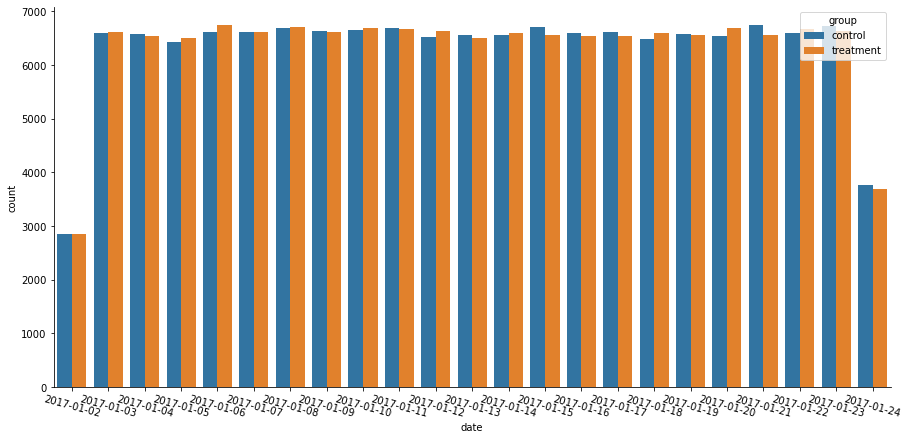

In [75]:
order=df2.date.value_counts().sort_index().index
plt.figure(figsize=(15,7))
sns.countplot(data=df2,x='date',order=order,hue='group')
plt.xticks(rotation=-15);
sns.despine()

The test was performed for 23 days which is not bad considering the website's daily traffic that is around 6500 users.

G:\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1080x504 with 0 Axes>

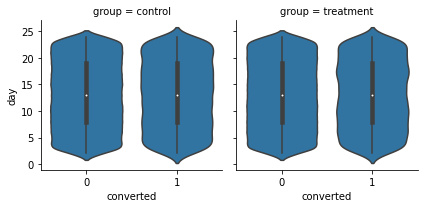

In [76]:
plt.figure(figsize=(15,7))
g=sns.FacetGrid(data=df2,col='group')
g.map(sns.violinplot,'converted','day');

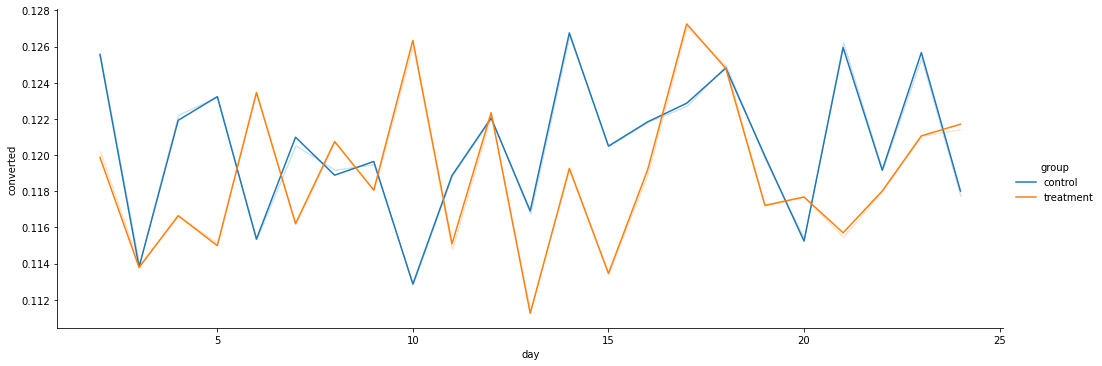

In [77]:
sns.relplot(data=df2,x='day',y='converted',hue='group',kind='line',ci=False,height=5,aspect=2.8);

Conversion varry between 11.2% and 12.5% for **both** groups during the 23 days of the test.

<a id='Conclusion'></a>
## Conclusion
- We fail to reject the null hypothesis $H_0: p_{new} = p_{old} $, there is no difference between old page and new page in terms of conversion.
- We should stick with the `old_page`,since we have no evidence for novelity effect or change aversion.